In [8]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import helpers as hlp
import os
import json
import tqdm

from scoring import compute_resolution, compute_main_metric
from matplotlib import pyplot as plt

# Preparation

In [9]:
# Path to the CSV file with evaluations
DATA_PATH = '../data/evaluations.csv'

# Path to the directory with predictions of similarities
PRED_PATH = '../predictions'

# Reading evaluations
df = pd.read_csv(DATA_PATH, sep='\t')
# Transforming evaluations into the dict of the form {reviewer: {paper1: expertise1, paper2: expertise2, ...}}
references, _ = hlp.to_dicts(df)

In [10]:
def score_performance(pred_file, references, valid_papers, bootstraps=None):
    """Compute the main metric for predicted similarity together with bootstrapped values for confidence intervals

    :param pred_file: Name of the file where predicted similarities are stored (file must be in the PRED_PATH dir)
    :param references: Ground truth values of expertise
    :param valid_papers: Papers to include in evaluation
    :param bootstraps: Subsampled reviewer pools for bootstrap computations
    :return: Score of the predictions + data to compute confidence intervals (if `bootstraps` is not None)
    """

    with open(os.path.join(PRED_PATH, pred_file), 'r') as handler:
        predictions = json.load(handler)

    valid_reviewers = list(predictions.keys())

    score = compute_main_metric(predictions, references, valid_papers, valid_reviewers)

    if bootstraps is None:
        return score

    variations = [compute_main_metric(predictions, references, valid_papers, vr) for vr in bootstraps]

    return score, variations

In [11]:
def score_resolution(pred_file, references, valid_papers, bootstraps=None):
    """Compute resolution ability of the algorithms (accuracy on hard/easy triples) together with bootstrapped
    values for confidence intervals

    :param pred_file: Name of the file where predicted similarities are stored (file must be in the PRED_PATH dir)
    :param references: Ground truth values of expertise
    :param valid_papers: Papers to include in evaluation
    :param bootstraps: Subsampled reviewer pools for bootstrap computations
    :return: Score of predictions on easy/hard triples + data to compute confidence intervals (if `bootstraps` is not None)
    """

    with open(os.path.join(PRED_PATH, pred_file), 'r') as handler:
        predictions = json.load(handler)

    valid_reviewers = list(predictions.keys())

    score_easy = compute_resolution(predictions, references, valid_papers, valid_reviewers, regime='easy')
    score_hard = compute_resolution(predictions, references, valid_papers, valid_reviewers, regime='hard')

    if bootstraps is None:
        return score_easy, score_hard

    variations_easy = [compute_resolution(predictions, references, valid_papers, vr, regime='easy')['score']
                                for vr in bootstraps]
    variations_hard = [compute_resolution(predictions, references, valid_papers, vr, regime='hard')['score']
                                for vr in bootstraps]

    return score_easy, score_hard, variations_easy, variations_hard

In [12]:
# Auxiliary functions to streamline computation of statistics.
# These functions account for the procedure we use to average out the noise in profile creation.

def get_mean(vals):
    """ Average out the noise in pointwise estimates of performance """
    return round(np.mean(vals), 2)

def get_ci(vals):
    """ Get 95% confidence intervals for the pointwise performance """

    # Average out the noise due to randomness in the profile creation
    boot = np.matrix(vals).mean(axis=0).tolist()[0]

    # Get confidence interval
    return f"[{round(np.percentile(boot, 2.5), 2)}; {round(np.percentile(boot, 97.5), 2)}]"

def get_diff(vals_main, vals_contrast):
    """ Difference in performance between two algorithms (main and contrast) """
    return round(np.mean(vals_main) - np.mean(vals_contrast), 2)

def get_diff_ci(vals_main, vals_contrast):
    """ 95% confidence interval for the difference in performance """

    boot = (np.matrix(vals_main) - np.matrix(vals_contrast)).mean(axis=0).tolist()[0]
    return f"[{round(np.percentile(boot, 2.5), 2)}; {round(np.percentile(boot, 97.5), 2)}]"

In [13]:
# list of all reviewers (58) who participated in our study
# list of all papers included in the dataset (463)
all_reviewers = list(references.keys())

all_papers = set()
for rev in references:
    all_papers = all_papers.union(references[rev].keys())

# list of reviewers whose Semantic Scholar profiles include papers available on arXiv (57)
# list of papers included in the dataset that have publicly available PDFs (457)
reviewers_with_pdf = list(set(all_reviewers) - {'1789029797'})

papers_with_pdf = list(set(all_papers) - {'203da29a37a983c487ce75a894b0d70698077bf5', '2eea63f896deed47cc0c0000e1482ec5c860fd0b',
                                          '35750f1908f405bb38b0708972f33fe07b378b64', '3c8853d4ae3ad2633c47e840a48951d62b64a5b4',
                                          'c9d7b1f9b13d6ea4ff45b908285cc65af959cc5b', 'no_ss'})

# 1. Main Eval (Section 6.1)

In this section we evaluate algorithms on the datasets `d_20_{x}.json, x \in {1, 2, ... 10}`. Specifically,
1. We evaluate algorithms in the `title+abstract` regime
2. We include `20` papers in the reviewers' profiles.
3. To average out the noise associated with the randomness in constructing reviewer profiles (due to ties between papers published in the same year), we consider `10` versions of the dataset (parametrized by `x`) and report values averaged across these versions.

### Results for Table 3

In [27]:
# List of algorithms to compare in Table 3
algorithms = ['tpms', 'elmo', 'specter', 'specter_mfr', 'acl']

# Number of bootstrap iterations
n_bootstrap = 1000

# We take only those reviewers whose profiles contain papers available on arxiv (57 reviewers).
valid_reviewers = reviewers_with_pdf

# Similarly, we predict similarities against papers that we were able to find PDFs for (457 papers).
valid_papers = papers_with_pdf

# Subsampling reviewer pools for bootstrapping
bootstraps = [np.random.choice(valid_reviewers, len(valid_reviewers), replace=True) for x in range(n_bootstrap)]

In [28]:
# Results dict
#
# 'alg': Algorithm we evaluate
# 'Pointwise': values of losses (main metric) on the original reviewer pool
# 'Variations': values of losses (main metric) on the bootstrapped reviewer pools
#
# Recall that we average out the noise in the profile creation by evaluating algorithms
# on 10 versions of the dataset that have slightly different reviewer profiles (due to randomness in
# breaking ties between papers published in the same year). To handle this, we first compute pointwise
# and bootstrapped values of loss on each of the 10 datasets and then average the values across the
# datasets

t3_res = {alg: {'pointwise': [], 'variations': []} for alg in algorithms}
profile_length = 20
rgm = 'ta' #we evaluate algorithms in the title+abstract regime

# Populating results dict
for algo in algorithms:
    print(f'Processing {algo}')
    # Inner iterations for averaging out the randomness in the profile creation
    for iteration in tqdm.tqdm(range(1, 11)):

        tmp = score_performance(f'{algo}_d_{profile_length}_{iteration}_{rgm}.json', references, valid_papers, bootstraps)

        t3_res[algo]['pointwise'].append(tmp[0])
        t3_res[algo]['variations'].append(tmp[1])

In [29]:
# Printing the data of Table 3
for algo in algorithms:

    mn = get_mean(t3_res[algo]['pointwise'])
    ci = get_ci(t3_res[algo]['variations'])

    if algo == 'tpms':
        print(f"{algo:>11}: {mn:>4} \t {ci:>12}")
    else:
        mn_diff = get_diff(t3_res[algo]['pointwise'], t3_res['tpms']['pointwise'])
        ci_diff = get_diff_ci(t3_res[algo]['variations'], t3_res['tpms']['variations'])
        print(f"{algo:>11}: {mn:>4} \t {ci:>12} \t {mn_diff:>5} \t {ci_diff:>13}")

       tpms: 0.28 	 [0.23; 0.33]
       elmo: 0.35 	 [0.31; 0.42] 	  0.07 	  [0.02; 0.14]
    specter: 0.27 	 [0.21; 0.34] 	 -0.01 	 [-0.06; 0.05]
specter_mfr: 0.24 	  [0.18; 0.3] 	 -0.04 	 [-0.09; 0.01]
        acl:  0.3 	 [0.25; 0.36] 	  0.02 	 [-0.02; 0.07]


# 2. TPMS Evaluation (Section 6.2)

In this section, we evaluate algorithms on the datasets `d_full_{y}_{x}.json, y \in {1, 2, ..., 20}, x \in {1, 2, ..., 5}`. Specifically:
1. `full` indicates that we only use papers with pdfs publicly available (which excludes 6 of the papers reported by participants and one reviewer whose past papers are not available on arXiv). In return, all papers in these datasets have PDFs available and we can  employ full texts of papers in similarity computation
2. We experiment with the profile length `y`, varying it from 1 to 20
3. We work with `5` copies of each dataset to average out the noise in the profile creation (parametrized by `x`)

### Results for Figure 2

In [17]:
# Regimes in which we evaluate the TPMS algorithm (title only, title+abstract, full text of papers)
regimes = ['t', 'ta', 'f']
n_bootstrap = 1000

# We take only those reviewers whose profiles contain papers available on arxiv (57 reviewers).
valid_reviewers = reviewers_with_pdf

# Similarly, we predict similarities against papers that we were able to find PDFs for (457 papers).
valid_papers = papers_with_pdf

bootstraps = [np.random.choice(valid_reviewers, len(valid_reviewers), replace=True) for x in range(n_bootstrap)]

# In this section we evaluate the tpms algorithm only
algo = 'tpms'

In [18]:
# Results dict
f2_res = {profile_length: {'t':[], 'ta': [], 'f': []} for profile_length in range(1, 21)}

# Different values of profile length
for profile_length in f2_res:
    # Different regimes ('t', 'ta', 'f')
    for regime in f2_res[profile_length]:
        # Iterations to average out the noise in profile creation
        for iteration in range(1, 6):

            f2_res[profile_length][regime].append(
                score_performance(f'{algo}_d_full_{profile_length}_{iteration}_{regime}.json', references, valid_papers)
            )

    for regime in f2_res[profile_length]:
        f2_res[profile_length][regime] = np.mean(f2_res[profile_length][regime])

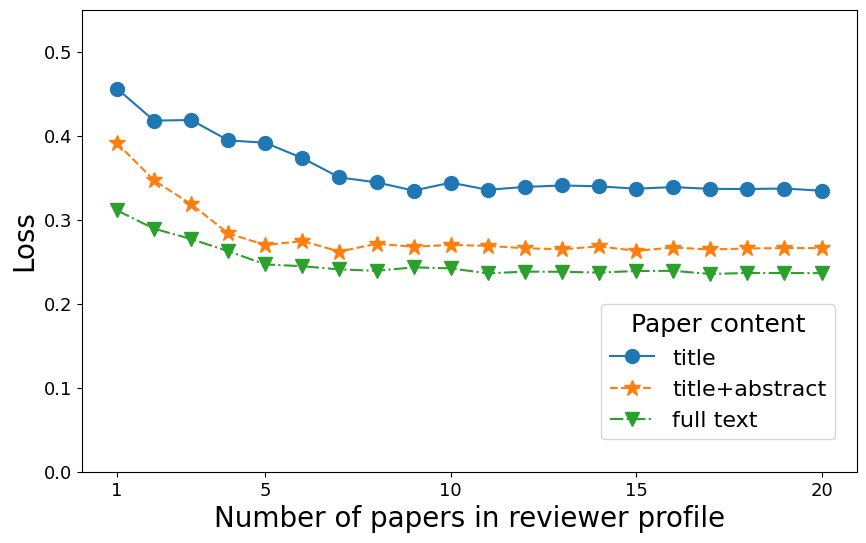

In [19]:
# Plotting Figure 2
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

num_paps = list(range(1, 21))

ax.plot(num_paps, [f2_res[x]['t'] for x in range(1, 21)], label='title', linestyle='-', marker='o', markersize=10)
ax.plot(num_paps, [f2_res[x]['ta'] for x in range(1, 21)], label='title+abstract', linestyle='--', marker='*', markersize=12)
ax.plot(num_paps, [f2_res[x]['f'] for x in range(1, 21)], label='full text', linestyle='-.', marker='v', markersize=10)

ax.set_ylim(0, 0.55)
ax.set_xticks([1, 5, 10, 15, 20])
ax.tick_params(labelsize=13)
ax.set_xlabel("Number of papers in reviewer profile", fontsize=20)
ax.set_ylabel("Loss", fontsize=20)
legend = ax.legend(fontsize=16, loc=(0.67, 0.07), title='Paper content')
_ = plt.setp(legend.get_title(),fontsize=18)

plt.savefig("../figures/tmps_analysis.pdf", bbox_inches='tight')

### Results for Table 4

In [20]:
# Results dict
# We set the profile length to 20 and compute confidence intervals for each choice of the paper content representation
# ('t', 'ta', 'f')
t4_res = {rgm: {'pointwise': [], 'variations': []} for rgm in regimes}
profile_length = 20

for rgm in regimes:
    # Iterations to average out the noise in profile creation
    for iteration in range(1, 6):

        tmp = score_performance(f'{algo}_d_full_{profile_length}_{iteration}_{rgm}.json', references, valid_papers, bootstraps)

        t4_res[rgm]['pointwise'].append(tmp[0])
        t4_res[rgm]['variations'].append(tmp[1])

In [21]:
# Printing the data of Table 4
for rgm in regimes:

    mn = get_mean(t4_res[rgm]['pointwise'])
    ci = get_ci(t4_res[rgm]['variations'])

    if rgm == 'ta':
        print(f"{rgm:>2}: {mn:>4} \t {ci:>12}")
    else:
        mn_diff = get_diff(t4_res[rgm]['pointwise'], t4_res['ta']['pointwise'])
        ci_diff = get_diff_ci(t4_res[rgm]['variations'], t4_res['ta']['variations'])
        print(f"{rgm:>2}: {mn:>4} \t {ci:>12} \t {mn_diff:>3} \t {ci_diff:>13}")

 t: 0.33 	 [0.29; 0.39] 	 0.07 	  [0.02; 0.12]
ta: 0.27 	 [0.21; 0.33]
 f: 0.24 	  [0.18; 0.3] 	 -0.03 	 [-0.09; 0.04]


# 3. Easy/Hard pairs (Section 7)

Finally, we evaluate the resolution abilities of the algorithms in the title+abstract regime with profile length of 20. For this, we work we the same data we used in Part 1 (Main Eval).

Additionally, we evaluate TPMS in the full text regime and for this evaluation we use the `d_full_20_*` datasets.

### Results for Table 5

In [22]:
# Algorithms we evaluate in this section (title+abstract regime with 20 papers in the reviewers' bibliographies)
algorithms = ['tpms', 'elmo', 'specter', 'specter_mfr', 'acl']
n_bootstrap = 1000

valid_reviewers = all_reviewers
valid_papers = all_papers

bootstraps = [np.random.choice(valid_reviewers, len(valid_reviewers), replace=True) for x in range(n_bootstrap)]

# Counting the number of hard/easy triples
info = score_resolution('constant_d_20_1_ta.json', references, valid_papers)
print(f"There are {info[0]['total']} easy triples and {info[1]['total']} hard triples")

There are 261 easy triples and 417 hard triples


In [23]:
# Result dicts for easy/hard triples
t5_res_easy = {algo: {'pointwise': [], 'variations': []} for algo in algorithms}
t5_res_hard = {algo: {'pointwise': [], 'variations': []} for algo in algorithms}

profile_length = 20
rgm = 'ta' #title+abstract

for algo in algorithms:
    for iteration in range(1, 11):

        tmp = score_resolution(f"{algo}_d_{profile_length}_{iteration}_{rgm}.json", references, valid_papers, bootstraps)

        t5_res_easy[algo]['pointwise'].append(tmp[0]['score'])
        t5_res_easy[algo]['variations'].append(tmp[2])

        t5_res_hard[algo]['pointwise'].append(tmp[1]['score'])
        t5_res_hard[algo]['variations'].append(tmp[3])

In [24]:
# We also evaluate the TPMS algorithm in the full text regime. For this, we use datasets 'd_full_20_*' that only contains
# papers with pdfs publicly available
algo = 'tpms'

t5_res_easy['tpms_f'] = {'pointwise': [], 'variations': []}
t5_res_hard['tpms_f'] = {'pointwise': [], 'variations': []}

# 57 reviewers whose profiles have some papers with links to arXiv
valid_reviewers = reviewers_with_pdf

# 457 papers from the dataset with PDFs publicly available
valid_papers = papers_with_pdf

bootstraps = [np.random.choice(valid_reviewers, len(valid_reviewers), replace=True) for x in range(n_bootstrap)]

profile_length = 20
rgm = 'f' #full texts of papers

for iteration in range(1, 6):

    tmp_full = score_resolution(f"{algo}_d_full_{profile_length}_{iteration}_{rgm}.json", references, valid_papers, bootstraps)

    t5_res_easy['tpms_f']['pointwise'].append(tmp_full[0]['score'])
    t5_res_easy['tpms_f']['variations'].append(tmp_full[2])

    t5_res_hard['tpms_f']['pointwise'].append(tmp_full[1]['score'])
    t5_res_hard['tpms_f']['variations'].append(tmp_full[3])

In [25]:
# Printing data for Table 5 (easy triples)

for algo in algorithms + ['tpms_f']:
        print(f"{algo:>11}: {get_mean(t5_res_easy[algo]['pointwise']):>4} \t {get_ci(t5_res_easy[algo]['variations']):>12}")

       tpms:  0.8 	 [0.73; 0.88]
       elmo:  0.7 	 [0.62; 0.78]
    specter: 0.85 	 [0.77; 0.92]
specter_mfr: 0.88 	 [0.81; 0.93]
        acl: 0.78 	  [0.7; 0.86]
     tpms_f: 0.84 	 [0.76; 0.91]


In [26]:
# Printing data for Table 5 (hard triples)

for algo in algorithms + ['tpms_f']:
        print(f"{algo:>11}: {get_mean(t5_res_hard[algo]['pointwise']):>4} \t {get_ci(t5_res_hard[algo]['variations']):>12}")

       tpms: 0.62 	 [0.55; 0.69]
       elmo: 0.57 	 [0.51; 0.63]
    specter: 0.57 	 [0.49; 0.64]
specter_mfr:  0.6 	 [0.53; 0.67]
        acl: 0.62 	 [0.55; 0.69]
     tpms_f: 0.64 	  [0.56; 0.7]
